### Hypothesis Generation to Strategic Exploration

In previous pattern agent follows a single, linear path of thought. If its initial approach is flawed or suboptimal, the entire process is compromised …

<p align="center">
  <img src="../../figures/parallel_hypothesis.png" width="800">
</p>

- Instead of a single line of reasoning, the system explicitly generates multiple, diverse strategies or “hypotheses” at the outset.\

- It then explores all of these paths in parallel, generating a solution for each one.

- Finally, a “judge” agent evaluates the competing solutions and selects the single best one. This creates a system that is more robust, more creative, and less likely to get stuck on a suboptimal path.


We will build a multi-agent system to tackle a creative marketing task. It will be composed of a Planner, parallel Workers, and a Judge. In this section my goal is to show a clear, qualitative improvement in the final output compared to what a single agent could produce.

First, to manage the complex flow of information between these agents, we need to define structured Pydantic models for their outputs. This is the glue that will hold our multi-agent system together.

In [4]:
from pydantic import BaseModel, Field
from typing import List

class MarketingHypothesis(BaseModel):
    """A Pydantic model for a single, distinct marketing angle or strategy to explore."""
    # A short, catchy name for the angle (e.g., 'The Tech Enthusiast').
    angle_name: str = Field(description="A short, catchy name for the marketing angle (e.g., 'The Tech Enthusiast').")
    # A concise description of the target audience and core message.
    description: str = Field(description="A one-sentence description of the target audience and core message for this angle.")

class Plan(BaseModel):
    """A Pydantic container for the Planner's output, holding multiple hypotheses."""
    # The list will contain exactly 3 distinct marketing hypotheses to be explored in parallel.
    hypotheses: List[MarketingHypothesis] = Field(description="A list of exactly 3 distinct marketing hypotheses to explore in parallel.")

class Slogan(BaseModel):
    """A Pydantic model for the output of a single copywriting Worker."""
    slogan: str = Field(description="The generated marketing slogan.")

class Evaluation(BaseModel):
    """A Pydantic model for the final, structured output of the Judge agent."""
    # A detailed critique comparing all the generated slogans.
    critique: str = Field(description="A detailed critique of all slogans, explaining the pros and cons of each.")
    # The single best slogan selected by the judge.
    best_slogan: str = Field(description="The single best slogan chosen from the list.")


In [148]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser


planner_output = JsonOutputParser(
    name="planner_parser",
    pydantic_object=Plan
)

worker_output = JsonOutputParser(
    name="worker_parser",
    pydantic_object=Slogan
)

judge_output = JsonOutputParser(
    name="judge_parser",
    pydantic_object=Evaluation
)

planner_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an expert marketing strategist. Your goal is to generate a diverse plan of distinct marketing angles for a given product. Create exactly three unique hypotheses.\n\n{format_instructions}"),
    ("human", "Please generate a marketing plan for the following product: {product_description}")
]).partial(format_instructions=planner_output.get_format_instructions())

worker_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an expert copywriter. Your task is to generate a catchy, concise, and powerful marketing slogan based on a specific marketing angle provided to you.\n\n{format_instructions}"),
    ("human", "Product: {product_description}\n\nMarketing Angle Name: {angle_name}\nMarketing Angle Description: {description}\n\nPlease generate one slogan that fits this angle perfectly.")
]).partial(format_instructions=worker_output.get_format_instructions())

judge_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a discerning marketing director. Your job is to critically evaluate a list of marketing slogans, provide a detailed critique, and select the single best one.\n\n{format_instructions}"),
    ("human", "Product: {product_description}\n\nHere are the slogans to evaluate:\n{slogans_to_evaluate}\n\nPlease provide your critique and choose the best slogan.")
]).partial(format_instructions=judge_output.get_format_instructions())

Next, we define the GraphState. This is a more complex state than in our previous pattern, as it needs to track the initial plan and the results from multiple, parallel worker branches.

In [151]:
from typing import List, TypedDict, Dict, Annotated
from langgraph.graph.message import add_messages


class GraphState(TypedDict):
    product_description: str
    plan: List[MarketingHypothesis]
     # merge the dictionaries from parallel branches, not replace them.
    worker_results: Annotated[Dict[str, Slogan], lambda a, b: {**a, **b}]
    final_evaluation: Evaluation
    performance_log: Annotated[List[str], add_messages] 

The most important piece here is worker_results: Annotated[Dict[str, Slogan], add_messages]. When our parallel worker nodes complete, each will return a small dictionary with its own result. The add_messages reducer function instructs LangGraph to merge these dictionaries into a single, comprehensive worker_results object in the final state, so that no data is lost.

Now, let’s define the Planner agent, which is the first node in our graph.

In [152]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

llm = ChatHuggingFace(
    llm=HuggingFaceEndpoint(
        model="Qwen/Qwen3-4B-Instruct-2507"
    )
)

In [153]:
import time

def planner_node(state: GraphState):
    """The Planner node: generates the initial marketing plan with multiple, diverse hypotheses."""
    print("--- AGENT: Planner is thinking... ---")
    start_time = time.time()

    planner_chain = planner_prompt | llm | planner_output
    plan = planner_chain.invoke({"product_description": state['product_description']})
    
    execution_time = time.time() - start_time
    log_entry = f"[Planner] Generated {len(plan["hypotheses"])} hypotheses in {execution_time:.2f}s."
    print(log_entry)

    state["plan"] = plan["hypotheses"]
    state["performance_log"] = [log_entry]

    return state

In [154]:
# Node 2: The Worker Agent
def worker_node(state: GraphState):
    """Generates a slogan for a single hypothesis. This node will be run in parallel for each hypothesis."""
    # The `config` object contains runtime information. `configurable` is a special key.
    # We'll retrieve the specific hypothesis for this worker instance from the config.
    hypothesis = state["hypothesis"]
    angle_name = hypothesis["angle_name"]
    
    print(f"--- AGENT: Worker for '{angle_name}' is thinking... ---")
    start_time = time.time()
    
    worker_chain = worker_prompt | llm | worker_output
    result = worker_chain.invoke({
        "product_description": state["product_description"],
        "angle_name": angle_name,
        "description": hypothesis["description"]
    })
    
    execution_time = time.time() - start_time
    log_entry = f"[Worker-{angle_name}] Generated slogan in {execution_time:.2f}s."
    print(log_entry)

    return {
        "worker_results": {angle_name: result},
        "performance_log": [log_entry]
    }

In [155]:
# Node 3: The Judge Agent
def judge_node(state: GraphState):
    """Evaluates all worker results and selects the best one."""
    print("--- AGENT: Judge is evaluating... ---")
    start_time = time.time()
    
    # Format the worker results for the judge's prompt
    slogans_to_evaluate = ""
    for angle, slogan_obj in state['worker_results'].items():
        slogans_to_evaluate += f"Angle: {angle}\nSlogan: {slogan_obj["slogan"]}\n\n"
    
    judge_chain = judge_prompt | llm | judge_output
    evaluation = judge_chain.invoke({
        "product_description": state['product_description'],
        "slogans_to_evaluate": slogans_to_evaluate
    })
    
    execution_time = time.time() - start_time
    log_entry = f"[Judge] Evaluated {len(state['worker_results'])} slogans in {execution_time:.2f}s."
    print(log_entry)
    
    return {
        "final_evaluation": evaluation,
        "performance_log": [log_entry]
    }

### Defining Graph Edges and Logic for Parallelism

This is the most critical part of the implementation. We will use a function as a conditional edge to dynamically spawn our parallel workers. This is the dynamic parallelism pattern from the 'Orchestrator-Worker' LangGraph blog, using the Send object. Send tells the graph to dispatch a task to a specific node with a specific input.

In [156]:
from langgraph.graph import StateGraph, END
from langgraph.types import Send

def scatter_to_workers(state: GraphState) -> List[Send]:
    """A special edge function that scatters the plan to parallel workers."""
    print("--- ORCHESTRATOR: Scattering tasks to workers --- ")
    # This list of `Send` objects will trigger parallel executions of the 'worker' node.
    # Each `Send` object passes a different hypothesis to a different instance of the worker.
    print(state)
    tasks = [
        Send(
            "worker",
            {
                "product_description": state["product_description"],
                "hypothesis": hypothesis
            } # Pass specific hypothesis to each worker
        )
        for hypothesis in state['plan']
    ]
    return tasks

In [138]:
# Initialize a new graph
workflow = StateGraph(GraphState)

# Add the nodes
workflow.add_node("planner", planner_node)
workflow.add_node("worker", worker_node)
workflow.add_node("judge", judge_node)

# Define the workflow
workflow.set_entry_point("planner")

# The planner node's output is scattered to the workers
workflow.add_conditional_edges("planner", scatter_to_workers)

# After all workers finish, their results are passed to the judge
workflow.add_edge("worker", "judge")

# The judge is the final step
workflow.add_edge("judge", END)

# Compile the graph
app = workflow.compile()

print("Graph constructed and compiled successfully.")
print("The multi-agent system is ready.")

Graph constructed and compiled successfully.
The multi-agent system is ready.


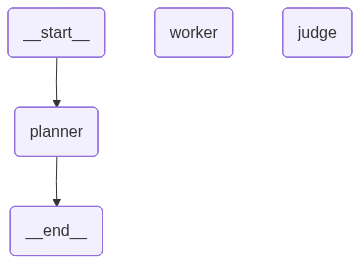

In [139]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

### Running and Analyzing the Multi-Agent System

In [140]:
inputs = {
    "product_description": "A smart coffee mug that uses AI to maintain the perfect coffee temperature and provides personalized energy level suggestions.",
    "performance_log": []
}

app.invoke(inputs)

--- AGENT: Planner is thinking... ---
[Planner] Generated 3 hypotheses in 2.48s.
--- ORCHESTRATOR: Scattering tasks to workers --- 
{'product_description': 'A smart coffee mug that uses AI to maintain the perfect coffee temperature and provides personalized energy level suggestions.', 'plan': [{'angle_name': 'The Morning Mindset', 'description': 'Target early risers and productivity-focused professionals who use the mug to start their day with personalized energy suggestions, framing the product as a smart companion for mental clarity and sustained focus.'}, {'angle_name': 'The Sustainable Sip', 'description': "Appeal to eco-conscious consumers by highlighting the mug's reusable, long-lasting design and AI-powered efficiency, positioning it as a responsible, smart lifestyle choice that reduces single-use waste."}, {'angle_name': "The Coffee Connoisseur's Guide", 'description': 'Position the product for coffee enthusiasts by emphasizing its ability to maintain optimal temperature and de

{'product_description': 'A smart coffee mug that uses AI to maintain the perfect coffee temperature and provides personalized energy level suggestions.',
 'plan': [{'angle_name': 'The Morning Mindset',
   'description': 'Target early risers and productivity-focused professionals who use the mug to start their day with personalized energy suggestions, framing the product as a smart companion for mental clarity and sustained focus.'},
  {'angle_name': 'The Sustainable Sip',
   'description': "Appeal to eco-conscious consumers by highlighting the mug's reusable, long-lasting design and AI-powered efficiency, positioning it as a responsible, smart lifestyle choice that reduces single-use waste."},
  {'angle_name': "The Coffee Connoisseur's Guide",
   'description': 'Position the product for coffee enthusiasts by emphasizing its ability to maintain optimal temperature and deliver tailored brewing insights, turning the mug into a premium tool for perfect every sip.'}],
 'worker_results': {'T

In [141]:
import json

inputs = {
    "product_description": "A smart coffee mug that uses AI to maintain the perfect coffee temperature and provides personalized energy level suggestions.",
    "performance_log": [],
    "worker_results": {}
}

step_counter = 1

# Use stream_mode="updates" to see which node produced each update
for chunk in app.stream(inputs, stream_mode="updates"):
    # chunk is a dict like {"node_name": {state_updates}}
    for node_name, state_update in chunk.items():
        print(f"\n{'*' * 100}")
        print(f"**Step {step_counter}: {node_name.capitalize()} Node{' (Parallel)' if node_name == 'worker' else ''}**")
        print(f"{'*' * 100}")
        
        print("\nState Update from this node:")
        try:
            print(json.dumps(state_update, indent=4, default=str))
        except:
            print(state_update)

        print(f"\n{'-' * 100}")
        if node_name == "planner":
            print("✓ Planner generated marketing hypotheses. Next: scatter to workers.")
        elif node_name == "worker":
            print("✓ Worker generated a slogan for one hypothesis.")
        elif node_name == "judge":
            print("✓ Judge evaluated all slogans and selected the best one.")
        print(f"{'-' * 100}")
        
        step_counter += 1

# Get final state
final_state = app.invoke(inputs)
print("\n" + "=" * 100)
print("FINAL STATE")
print("=" * 100)
print(json.dumps(final_state, indent=4, default=str))

--- AGENT: Planner is thinking... ---
[Planner] Generated 3 hypotheses in 2.96s.
--- ORCHESTRATOR: Scattering tasks to workers --- 
{'product_description': 'A smart coffee mug that uses AI to maintain the perfect coffee temperature and provides personalized energy level suggestions.', 'plan': [{'angle_name': 'The Morning Mindset', 'description': 'Targeting early risers and productivity enthusiasts with a message that the smart coffee mug helps them start their day with optimal energy by syncing coffee warmth and personalized energy tips to match their daily goals.'}, {'angle_name': 'The Health-Conscious Caffeine Guide', 'description': 'Appealing to health-aware consumers by positioning the mug as an intelligent wellness tool that adjusts coffee temperature and suggests energy levels based on user’s fitness, sleep, and activity data.'}, {'angle_name': 'The Tech-Savvy Sips', 'description': 'Focusing on tech enthusiasts and gadget lovers who value innovation, emphasizing the AI-driven tem

Now for the final, quantitative proof. Let’s analyze the performance log to see the benefits of parallel execution.

In [147]:
total_time = 0
planner_time = 0
worker_times = []
judge_time = 0

# Parse our performance log to extract the timing for each stage.
for log in final_state['performance_log']:
    time_val = float(log.content.split(' ')[-1].replace('s', '').rstrip("."))
    if "[Planner]" in log.content:
        planner_time = time_val
    elif "[Worker-" in log.content:
        worker_times.append(time_val)
    elif "[Judge]" in log.content:
        judge_time = time_val

# The total time of a parallel step is the time of the longest-running task.
parallel_worker_time = max(worker_times) if worker_times else 0

# The total time of the entire workflow.
total_execution_time = planner_time + parallel_worker_time + judge_time
print(f"Total Execution Time: {total_execution_time:.2f} seconds\n")
print("Breakdown:")
print(f" - Planner: {planner_time:.2f} seconds")
print(f" - Parallel Workers (longest path): {parallel_worker_time:.2f} seconds")
print(f" - Judge: {judge_time:.2f} seconds\n")

# Now, we simulate what would have happened in a sequential workflow.
sequential_worker_time = sum(worker_times)
time_saved = sequential_worker_time - parallel_worker_time

Total Execution Time: 8.87 seconds

Breakdown:
 - Planner: 2.66 seconds
 - Parallel Workers (longest path): 1.19 seconds
 - Judge: 5.02 seconds

